In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.optimize as opt
import datetime as dt
import requests
import json
import os
from typing import Tuple, List, Dict
import abc

In [2]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', 500)

# Prepare data

In [3]:
def get_100_candles(ticker: str, tf: str, timestamp_ms_from: int):
    params = {
        'instId': ticker,
        'bar': tf,
        'after': timestamp_ms_from,
    }
    responce = requests.get('https://www.okx.com/api/v5/market/history-mark-price-candles', params)
    if not responce.ok:
        print('Bad request', responce.text)
        return
    candles = []
    for cs in json.loads(responce.text)['data']:
        candle = {
            'dt': dt.datetime.fromtimestamp(int(cs[0]) // 1000),
            'o': float(cs[1]),
            'h': float(cs[2]),
            'l': float(cs[3]),
            'c': float(cs[4]),
        }
        candles.append(candle)
    return candles

In [4]:
def get_timestamp_ms_range(from_date: dt.datetime, till_date: dt.datetime, delta: dt.timedelta):
    ts_range = []
    t = till_date
    while t > from_date:
        timestamp_ms = int(t.timestamp() * 1000)
        ts_range.append(timestamp_ms)
        t -= 100 * delta
    return ts_range

In [5]:
def get_candles_history(ticker: str, tf: str, from_date: dt.datetime, till_date: dt.datetime):
    """
    Get candlestick history of a ticker from OKX 
    """
    tf_to_timedelta = {
        '1D': dt.timedelta(days=1),
        '4H': dt.timedelta(hours=4),
    }
    candles = []
    ts_range = get_timestamp_ms_range(from_date, till_date, tf_to_timedelta[tf])
    for ts_ms in ts_range:
        new_candles = get_100_candles(ticker, tf, ts_ms)
        if new_candles:
            candles.extend(new_candles)
    if len(candles) == 0:
        return 
    df_candles = pd.DataFrame(candles).sort_values('dt')
    return df_candles[df_candles['dt'].between(from_date, till_date)].drop_duplicates('dt').reset_index(drop=True)

In [6]:
DATA_DIR = 'data'
DATA_FILENAME = 'crypto.csv'

path_to_data = os.path.join(DATA_DIR, DATA_FILENAME)
if not os.path.exists(path_to_data):
    tickers = ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT',
            'SOL-USDT', 'DOGE-TRX', 'TRX-USDT', 'LTC-USDT', 'TON-USDT',
            ]
    tf = '1D'
    date_from = dt.datetime(2020, 1, 1)
    date_till = dt.datetime(2025, 1, 1)
    data = []
    for ticker in tickers:
        print(ticker)
        df = get_candles_history(ticker, tf, date_from, date_till)
        if df is not None:
            ts = pd.Series(data=df['c'].values, index=df['dt'], name=ticker)
            data.append(ts)
    data = pd.concat(data, axis=1)
    data.to_csv(path_to_data)

data = pd.read_csv(path_to_data, index_col='dt', parse_dates=['dt'])
data.dropna(inplace=True)
data.sort_index(inplace=True)
print(data.shape)

(736, 9)


In [7]:
np.argmin(data.isna().sum(axis=1))

np.int64(0)

In [8]:
N = data.shape[1]
ASSET_NAMES = data.columns.tolist()

print('observations', data.shape[0])
print('from', data.index.min())
print('till', data.index.max())
print('ccys', ASSET_NAMES)

observations 736
from 2022-12-27 19:00:00
till 2024-12-31 19:00:00
ccys ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT', 'SOL-USDT', 'TRX-USDT', 'LTC-USDT', 'TON-USDT']


# Optimal frontier

In [9]:
def mu_cov_estimate(df, period, max_leng=None):
    ret = (df.diff(period) / df.shift(period)).dropna()
    if max_leng:
        ret = ret.tail(max_leng)
    if ret.shape[0] < 2:
        raise Exception(f'too short dataset: {df.shape} with period {period}')
    mu_hat = ret.mean(axis=0).values
    cov_hat = ret.cov().values
    return mu_hat, cov_hat

In [10]:
def markowitz_solver(mu_hat, cov_hat, risk_tolerance):
    def objective(x, mu, cov, risk_tolerance):
        x = x.reshape((-1, 1))
        return x.T @ cov @ x - risk_tolerance * x.T @ mu

    def constraint(x):
        return np.abs(x).sum() - 1

    eq_cons = {
        'type': 'eq',
        'fun': constraint
    }

    bounds = [(-1, 1) for i in range(n)]
    x0 = np.zeros(n)
    x0[0] = 1

    sol = opt.minimize(
        fun=objective,
        x0=x0,
        args=(mu_hat, cov_hat, risk_tolerance),
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    return sol.x.reshape((-1, 1)), sol

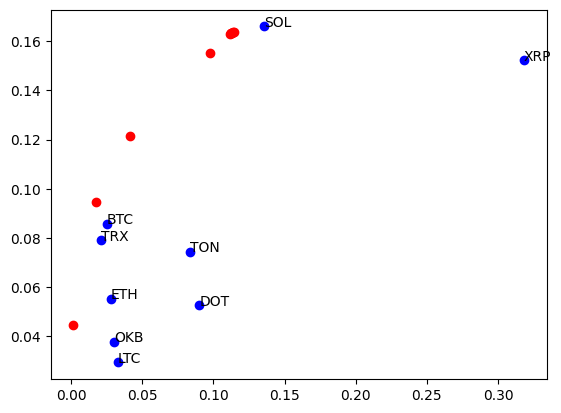

In [11]:
mu_hat_global, cov_hat_global = mu_cov_estimate(data, 31)
n = data.shape[1]

single_asset_portfolios = []
for i in range(n):
    w = np.zeros((n, 1))
    w[i] = 1
    port = {
        'w': w,
        'name': f'{data.columns[i].split('-')[0]}',
        'mu_port': (w.T @ mu_hat_global).item(),
        'cov_port': (w.T @ cov_hat_global @ w).item(),
    }
    single_asset_portfolios.append(port)

frontier_portfolios = []
risk_toler_range = set(np.linspace(0.1, 5, 10).round(2))
for risk_tolerance in risk_toler_range:
    w, meta = markowitz_solver(mu_hat_global, cov_hat_global, risk_tolerance)
    if meta.success:
        port = {
            'w': w,
            'name': f'markowitz_{risk_tolerance}',
            'mu_port': (w.T @ mu_hat_global).item(),
            'cov_port': (w.T @ cov_hat_global @ w).item(),
        }
        frontier_portfolios.append(port)
    else:
        print('not successful optimization', risk_tolerance, meta)

plt.scatter(
    x=[p['cov_port'] for p in single_asset_portfolios],
    y=[p['mu_port'] for p in single_asset_portfolios],
    c='blue',
)
for p in single_asset_portfolios:
    plt.annotate(
        p['name'],
        (p['cov_port'], p['mu_port'])
    )

plt.scatter(
    [p['cov_port'] for p in frontier_portfolios],
    [p['mu_port'] for p in frontier_portfolios],
    c='red',
    marker='o'
)

<Axes: >

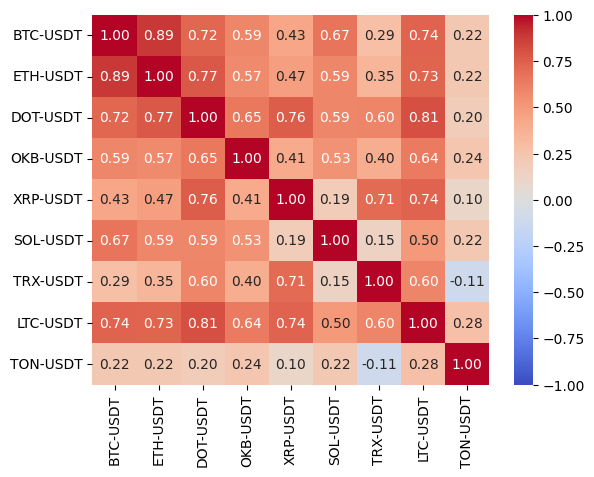

In [12]:
d = cov_hat_global.diagonal().reshape((-1, 1))
corr_hat_global = cov_hat_global / (d * d.T)**0.5

sns.heatmap(corr_hat_global, 
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True, 
            fmt='.2f', 
            xticklabels=data.columns, 
            yticklabels=data.columns)

# Evaluate strategies

In [13]:
def timeseries_split(df:pd.DataFrame, input_width:int, offset:int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    size = df.shape[0]
    total_width = input_width + offset
    for i in range(size - total_width):
        yield i, df.iloc[i:i+input_width], df.iloc[i+input_width: i+total_width]

In [14]:
class Strategy:
    def __init__(self, offset):
        self.offset = offset
        self.eval_hist = []

    @abc.abstractmethod
    def fit(self, df):
        pass
    
    def predict(self, df):
        return self.w
    
    def evaluate(self, train, test):
        open_dt = train.index[-1]
        close_dt = test.index[-1]
        open_price = train.loc[open_dt].values.reshape((-1, 1))
        close_price = test.loc[close_dt].values.reshape((-1, 1))

        dprice = close_price - open_price
        roi = dprice / open_price

        roi_port = (self.predict(train).T @ roi).item()
        self.eval_hist.append({
            'open_dt': open_dt,
            'close_dt': close_dt,
            'roi_port': roi_port,
        })

    @property
    def roi_mean(self):
        return pd.DataFrame(self.eval_hist)['roi_port'].mean().item()
    
    @property
    def roi_std(self):
        return pd.DataFrame(self.eval_hist)['roi_port'].std().item()
    
    @property
    def value_at_risk(self):
        return pd.DataFrame(self.eval_hist)['roi_port'].quantile(0.05).item()
    
    @property
    def ci(self):
        return (pd.DataFrame(self.eval_hist)['roi_port'].quantile(0.05).item(), pd.DataFrame(self.eval_hist)['roi_port'].quantile(0.95).item())
        
    @property
    def name(self):
        return self.__class__.__name__
    
    def __str__(self):
        return self.name

In [15]:
class SingleAsset(Strategy):
    def __init__(self, offset, asset_name, short=False):
        super().__init__(offset)
        self.asset_name = asset_name
        self.short = short
        
    def fit(self, df):
        self.n = df.shape[1]
        if self.asset_name in df.columns:
            self.arg_asset = np.argwhere(df.columns == self.asset_name).item()
        self.w = np.zeros((n, 1))
        self.w[self.arg_asset] = -1 if self.short else 1

    @property
    def name(self):
        return f'{super().name}({self.asset_name})'

In [16]:
class Markowitz(Strategy):
    def __init__(self, offset, risk_tolerance, history_leng):
        super().__init__(offset)
        self.risk_tolerance = risk_tolerance
        self.history_leng = history_leng
    
    def fit(self, df):
        self.w = np.zeros((n, 1))
        if df.shape[0] < self.offset + 2:
            return
        self.mu_hat, self.cov_hat = mu_cov_estimate(df, self.offset, self.history_leng)
        w, meta = markowitz_solver(self.mu_hat, self.cov_hat, self.risk_tolerance)
        if meta.success:
            self.w = w
            self.mu_port = (self.w.T @ self.mu_hat).item()
            self.std_port = (self.w.T @ self.cov_hat @ self.w).item()**0.5

    @property
    def name(self):
        return f'{super().name}({self.risk_tolerance: .2f}, {self.history_leng})'

In [17]:
class LastBest(Strategy):
    def __init__(self, offset):
        super().__init__(offset)

    def fit(self, df):
        n = df.shape[1]
        ret = df.diff(self.offset) / df.shift(self.offset)
        arg_best = np.argmax(ret.iloc[-1])
        self.best_asset_name = df.columns[arg_best]
        self.w = np.zeros((n, 1))
        self.w[arg_best] = 1 if ret.iloc[-1, arg_best] > 0 else - 1

In [18]:
# 1W investing period
offset = 30
input_width = offset * 5

portfolios = []
portfolios += [LastBest(offset)]
portfolios += [SingleAsset(offset, s) for s in ASSET_NAMES]
portfolios += [Markowitz(offset, rt, mh) for rt in [0, 0.5, 1, 2, 5] for mh in [5, 10, 50]]


data_input = data#.head(200) # MOCK

print(f'number of folds= {data_input.shape[0] - offset - input_width}')
print(f'strategies to test= {len(portfolios)}')
print('\n')

for fold, train, test in timeseries_split(data_input, input_width, offset):
    for port in portfolios:
        port.fit(train)
        port.evaluate(train, test)
        
for port in portfolios:
    print(f'{port.name: <25} roi_mean= {port.roi_mean: .2f}, roi_std= {port.roi_std:.2f}, VaR= {port.value_at_risk: .2f}, ci= ({port.ci[0]: .2f}, {port.ci[1]: .2f})')

number of folds= 556
strategies to test= 25


LastBest                  roi_mean=  0.15, roi_std= 0.36, VaR= -0.20, ci= (-0.20,  0.84)
SingleAsset(BTC-USDT)     roi_mean=  0.08, roi_std= 0.16, VaR= -0.12, ci= (-0.12,  0.39)
SingleAsset(ETH-USDT)     roi_mean=  0.05, roi_std= 0.17, VaR= -0.17, ci= (-0.17,  0.37)
SingleAsset(DOT-USDT)     roi_mean=  0.06, roi_std= 0.32, VaR= -0.26, ci= (-0.26,  0.60)
SingleAsset(OKB-USDT)     roi_mean=  0.02, roi_std= 0.14, VaR= -0.15, ci= (-0.15,  0.32)
SingleAsset(XRP-USDT)     roi_mean=  0.17, roi_std= 0.61, VaR= -0.21, ci= (-0.21,  1.12)
SingleAsset(SOL-USDT)     roi_mean=  0.19, roi_std= 0.36, VaR= -0.23, ci= (-0.23,  0.79)
SingleAsset(TRX-USDT)     roi_mean=  0.08, roi_std= 0.16, VaR= -0.10, ci= (-0.10,  0.28)
SingleAsset(LTC-USDT)     roi_mean=  0.03, roi_std= 0.19, VaR= -0.24, ci= (-0.24,  0.33)
SingleAsset(TON-USDT)     roi_mean=  0.11, roi_std= 0.30, VaR= -0.18, ci= (-0.18,  0.81)
Markowitz( 0.00, 5)       roi_mean=  0.04, roi_std= 0.13, VaR= -

C:\Users\tpolu\AppData\Local\Temp\ipykernel_8068\2078729275.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


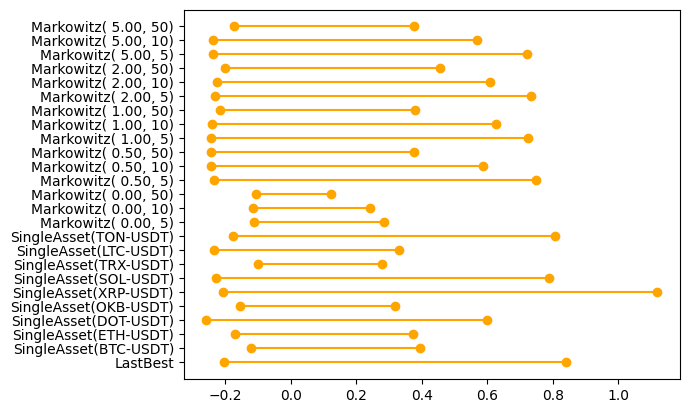

In [19]:
for (lower, upper), y in zip([p.ci for p in portfolios], range(len(portfolios))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(portfolios)), [p.name for p in portfolios])
plt.show()

<ErrorbarContainer object of 3 artists>

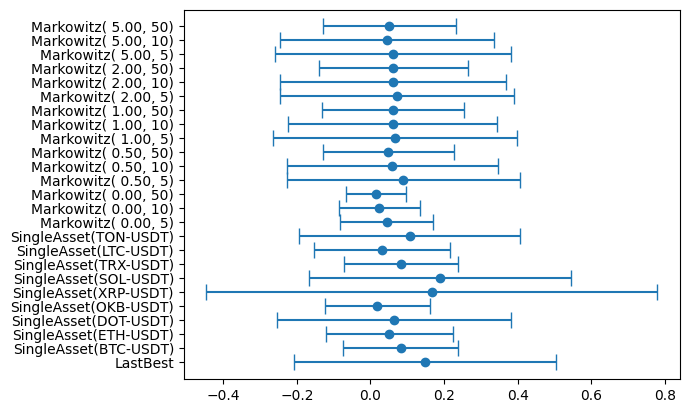

In [20]:
plt.errorbar(
    x=[p.roi_mean for p in portfolios],
    y=[p.name for p in portfolios],
    xerr=[p.roi_std for p in portfolios],
    fmt='o',
    capsize=6,
)

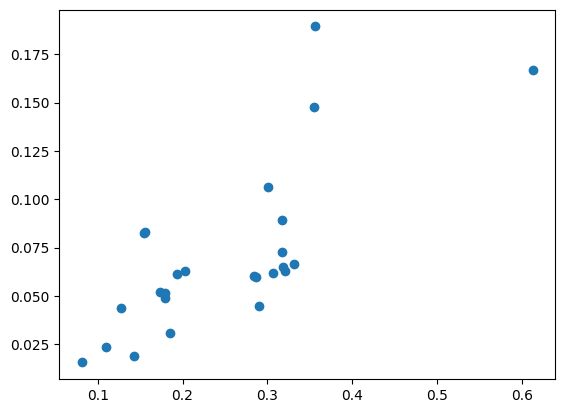

In [21]:
plt.scatter(
    [p.roi_std for p in portfolios],
    [p.roi_mean for p in portfolios]
)

# for p in portfolios:
#     plt.annotate(
#         p.name,
#         (p.roi_std, p.roi_mean)
#         )